# G27
Dave Brunner

### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import ReLU, Sequential, Conv1d, BatchNorm1d, MaxPool1d, Dropout, Linear, Flatten

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


### Load Data

In [3]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths = [TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES]

# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path = TEST + "y_test.txt"

In [4]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))


X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
n_input_signals = X_train.shape[2]
signal_sequence_length = X_train.shape[1]
print(f'X_train shape: {X_train.shape}\n'
      f'X_test shape: {X_test.shape}\n'
      f'Number of input signals: {n_input_signals}\n'
      f'Signal sequence length: {signal_sequence_length}')

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
Number of input signals: 9
Signal sequence length: 128


In [5]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1


def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]


def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)


Y_train = load_y(y_train_path)
Y_test = load_y(y_test_path)
print(Y_train.shape, Y_test.shape)

(7352, 1) (2947, 1)


In [6]:
# One-hot encoding
Y_train = one_hot(Y_train, N_CLASSES)
Y_test = one_hot(Y_test, N_CLASSES)
print(f'Y_train shape: {Y_train.shape}\n'
      f'Y_test shape: {Y_test.shape}')

Y_train shape: (7352, 6)
Y_test shape: (2947, 6)


#### Plot some samples

In [7]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = ...  # select sample of given class c
    X_train_per_class[c] = X_train[mask]

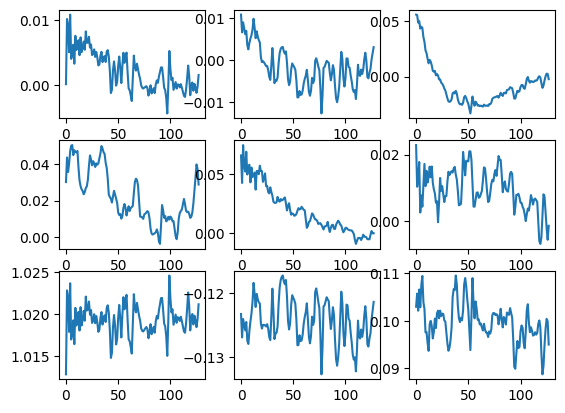

In [8]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        for j in range(np.minimum(X.shape[0], nsamples)):
            plt.plot(t, X[j, :, i])
    plt.show()


plot_lines(X_train_per_class[1], 1)

In [9]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0, 1))
stdevs = np.std(X_train, axis=(0, 1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f" % (means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Dataset

If suitable specify Dataset (e.g. in PyTorch).

In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

In [11]:
print(f'Y_train_tensor shape: {Y_train_tensor.shape}\n'
      f'Y_test_tensor shape: {Y_test_tensor.shape}')

Y_train_tensor shape: torch.Size([7352, 6])
Y_test_tensor shape: torch.Size([2947, 6])


### Normalization



In [12]:
mean = torch.mean(X_train_tensor)
std = torch.std(X_train_tensor)

X_train_tensor_norm = (X_train_tensor - mean) / std
X_test_tensor_norm = (X_test_tensor - mean) / std

In [13]:
print(f'Std of X_train_tensor_norm: {torch.std(X_train_tensor_norm):.4f}\n'
      f'Std of X_train_tensor     : {torch.std(X_test_tensor):.4f}\n'
      '----------------------------------\n'
      f'Std of X_test_tensor_norm: {torch.std(X_test_tensor_norm):.4f}\n'
      f'Std of X_test_tensor     : {torch.std(X_test_tensor):.4f}')

Std of X_train_tensor_norm: 1.0000
Std of X_train_tensor     : 0.3957
----------------------------------
Std of X_test_tensor_norm: 0.9839
Std of X_test_tensor     : 0.3957


In [14]:
training_data = torch.utils.data.TensorDataset(X_train_tensor_norm, Y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor_norm, Y_test_tensor)

assert len(training_data) == len(X_train)
assert len(test_data) == len(Y_test)

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with a single layer of LSTM
* Model with several layers of LSTMs
* Model with several CNN layers
* MLP

Try with different number of units. Add regularisation if needed (e.g. when working with MLPs).

Report about your findings.

### Single Layer SimpleRNN

In [15]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()

        # Defining the number of h layers and the nodes in each layer
        self.layer_size = layer_size
        self.hidden_size = hidden_size

        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.rnn(x)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1]
        # Convert the final state to our desired output shape (batch_size, output_size)
        out = self.fc(out)

        return out

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()

        # Defining the number of h layers and the nodes in each layer
        self.layer_size = layer_size
        self.hidden_size = hidden_size

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.lstm(x)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1]
        # Convert the final state to our desired output shape (batch_size, output_size)
        out = self.fc(out)

        return out

In [17]:
class PrintForward(nn.Module):
    @staticmethod
    def forward(x):
        print(x.shape)
        return x

class CNN_1D(nn.Module):
    def __init__(self, input_size, num_classes, activation_function=ReLU(), dropout_rate=0):
        super(CNN_1D, self).__init__()
        self.model = Sequential(
            Conv1d(input_size, 32, 1),  # 32 * 128
            BatchNorm1d(32),
            activation_function,
            

            Conv1d(32, 64, 3, 1),  # 64 * 126
            BatchNorm1d(64),
            activation_function,

            MaxPool1d(2),  # 64 * 63

            Conv1d(64, 128, 3, 1),  # 128 * 61
            BatchNorm1d(128),
            activation_function,

            Dropout(dropout_rate),
            Flatten(),
            # PrintForward(),
            Linear(128, 128),
            # PrintForward(),
            # BatchNorm1d(128),
            activation_function,

            Linear(128, num_classes),
        )

    def forward(self, x):
        return self.model(x)

In [18]:
hidden_size = 64
model = RNNModel(input_size=n_input_signals, hidden_size=hidden_size, layer_size=1, num_classes=N_CLASSES).to(device)
# summary(model, input_size=(signal_sequence_length, N_CLASSES))

In [19]:
def train_model(model, n_epochs, batch_size, optimizer, criterion, gradient_clipping=True):
    accuracy_hist_train = []
    accuracy_hist_test = []
    loss_hist_train = []
    loss_hist_test = []

    train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
    train_loader_eval = torch.utils.data.DataLoader(dataset=training_data, batch_size=len(training_data), shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)

    print('Training model...')
    for epoch in range(n_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # Pass data through the network
            output = model(data)
            # Calculate loss
            loss = criterion(output, target)
            # Backpropagate. Updates the gradients buffer on each parameter
            loss.backward()
            # Clip gradients to prevent exploding gradients
            if gradient_clipping:
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update weights
            optimizer.step()

        # test 
        with torch.no_grad():
            # train set ----------------
            correct = 0
            total = 0
            loss = 0
            for data, target in train_loader_eval:
                pred = model(data)
                loss += criterion(pred, target).item()
                _, predicted = torch.max(pred.data, 1)
                target = torch.max(target, 1)[1]
                total += target.size(0)
                correct += (predicted == target).sum().item()
            accuracy = correct / total
            accuracy_hist_train.append(accuracy)
            loss_hist_train.append(loss)

            # test set ----------------
            correct = 0
            total = 0
            loss = 0
            for data, target in test_loader:
                pred = model(data)
                loss += criterion(pred, target).item()
                _, predicted = torch.max(pred.data, 1)
                target = torch.max(target, 1)[1]
                total += target.size(0)
                correct += (predicted == target).sum().item()
            accuracy = correct / total
            accuracy_hist_test.append(accuracy)
            loss_hist_test.append(loss)

        print(
            f'Epoch {epoch + 1}, Loss: train={loss_hist_train[-1]:.4f}, test={loss_hist_test[-1]:.4f} | Accuracy: train={accuracy_hist_train[-1]:.4f}, test={accuracy_hist_test[-1]:.4f}')
    return {'train': [accuracy_hist_train, loss_hist_train], 'test': [accuracy_hist_test, loss_hist_test]}


def print_hist(history, title):
    plt.figure(1, figsize=(15, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(history['train'][1], label='Train Loss')
    plt.plot(history['test'][1], label='Test Loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1)
    plt.plot(history['train'][0], label='Train accuracy')
    plt.plot(history['test'][0], label='Test accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

Training model...
Epoch 1, Loss: train=1.1995, test=1.2568 | Accuracy: train=0.4951, test=0.4768
Epoch 2, Loss: train=1.0215, test=1.1572 | Accuracy: train=0.5600, test=0.5080
Epoch 3, Loss: train=0.9714, test=1.1049 | Accuracy: train=0.5703, test=0.5209
Epoch 4, Loss: train=0.7019, test=0.8370 | Accuracy: train=0.6892, test=0.6315
Epoch 5, Loss: train=0.7848, test=0.9211 | Accuracy: train=0.6347, test=0.5738
Epoch 6, Loss: train=0.6325, test=0.7422 | Accuracy: train=0.7014, test=0.6451
Epoch 7, Loss: train=0.6615, test=0.7850 | Accuracy: train=0.7239, test=0.6800
Epoch 8, Loss: train=0.6249, test=0.7442 | Accuracy: train=0.7164, test=0.6790
Epoch 9, Loss: train=0.6095, test=0.7207 | Accuracy: train=0.7369, test=0.6977
Epoch 10, Loss: train=0.6491, test=0.8127 | Accuracy: train=0.7053, test=0.6586
Epoch 11, Loss: train=0.8762, test=0.9733 | Accuracy: train=0.6227, test=0.6138
Epoch 12, Loss: train=0.6679, test=0.8136 | Accuracy: train=0.6953, test=0.6427
Epoch 13, Loss: train=0.6211, t

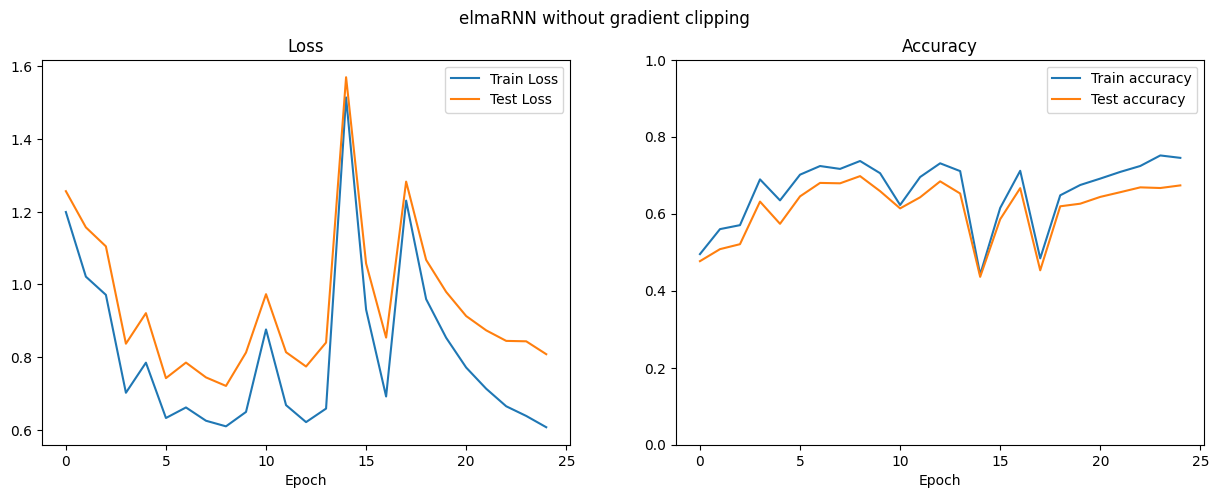

In [20]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=64, layer_size=1, num_classes=N_CLASSES).to(device)
adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=30, batch_size=128, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=False)
print_hist(history, 'elmaRNN without gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=1.0798, test=1.1994 | Accuracy: train=0.5586, test=0.5148
Epoch 2, Loss: train=1.0098, test=1.0947 | Accuracy: train=0.5768, test=0.5300
Epoch 3, Loss: train=0.9128, test=1.0196 | Accuracy: train=0.6285, test=0.5718
Epoch 4, Loss: train=0.7228, test=0.8922 | Accuracy: train=0.6848, test=0.6288
Epoch 5, Loss: train=0.6866, test=0.8647 | Accuracy: train=0.7013, test=0.6434
Epoch 6, Loss: train=0.7079, test=0.9198 | Accuracy: train=0.7100, test=0.6563
Epoch 7, Loss: train=1.1412, test=1.3004 | Accuracy: train=0.6387, test=0.5972
Epoch 8, Loss: train=1.1133, test=1.1532 | Accuracy: train=0.6015, test=0.5653
Epoch 9, Loss: train=0.6560, test=0.8543 | Accuracy: train=0.7005, test=0.6315
Epoch 10, Loss: train=0.5846, test=0.7918 | Accuracy: train=0.7338, test=0.6783
Epoch 11, Loss: train=0.6004, test=0.7949 | Accuracy: train=0.7447, test=0.6841
Epoch 12, Loss: train=0.5356, test=0.7643 | Accuracy: train=0.8137, test=0.7482
Epoch 13, Loss: train=0.5371, t

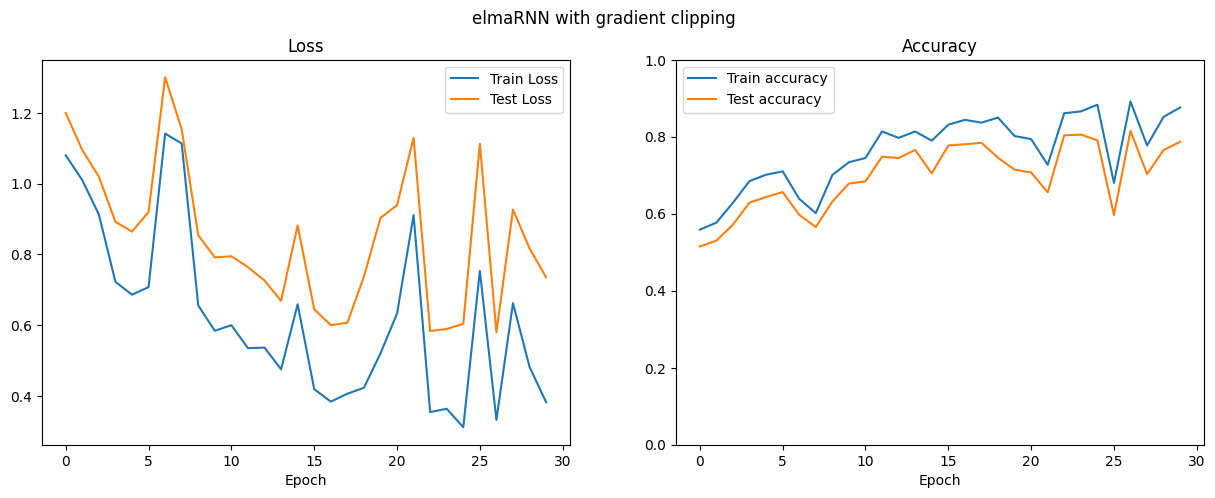

In [21]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=64, layer_size=1, num_classes=N_CLASSES).to(device)
adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=30, batch_size=128, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=True)
print_hist(history, 'elmaRNN with gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=1.1581, test=1.2120 | Accuracy: train=0.4803, test=0.4645
Epoch 2, Loss: train=1.1681, test=1.2858 | Accuracy: train=0.5094, test=0.4703
Epoch 3, Loss: train=0.7485, test=0.8590 | Accuracy: train=0.6321, test=0.5969
Epoch 4, Loss: train=0.6903, test=0.8621 | Accuracy: train=0.6910, test=0.6206
Epoch 5, Loss: train=0.7563, test=0.9045 | Accuracy: train=0.6590, test=0.6033
Epoch 6, Loss: train=0.6566, test=0.8256 | Accuracy: train=0.7266, test=0.6546
Epoch 7, Loss: train=0.7084, test=0.9559 | Accuracy: train=0.7235, test=0.6332
Epoch 8, Loss: train=0.5607, test=0.7372 | Accuracy: train=0.7769, test=0.7248
Epoch 9, Loss: train=0.4682, test=0.6196 | Accuracy: train=0.8127, test=0.7631
Epoch 10, Loss: train=0.4721, test=0.6517 | Accuracy: train=0.7907, test=0.7302
Epoch 11, Loss: train=0.7353, test=0.8819 | Accuracy: train=0.7043, test=0.6325
Epoch 12, Loss: train=0.4500, test=0.6047 | Accuracy: train=0.7982, test=0.7496
Epoch 13, Loss: train=0.4772, t

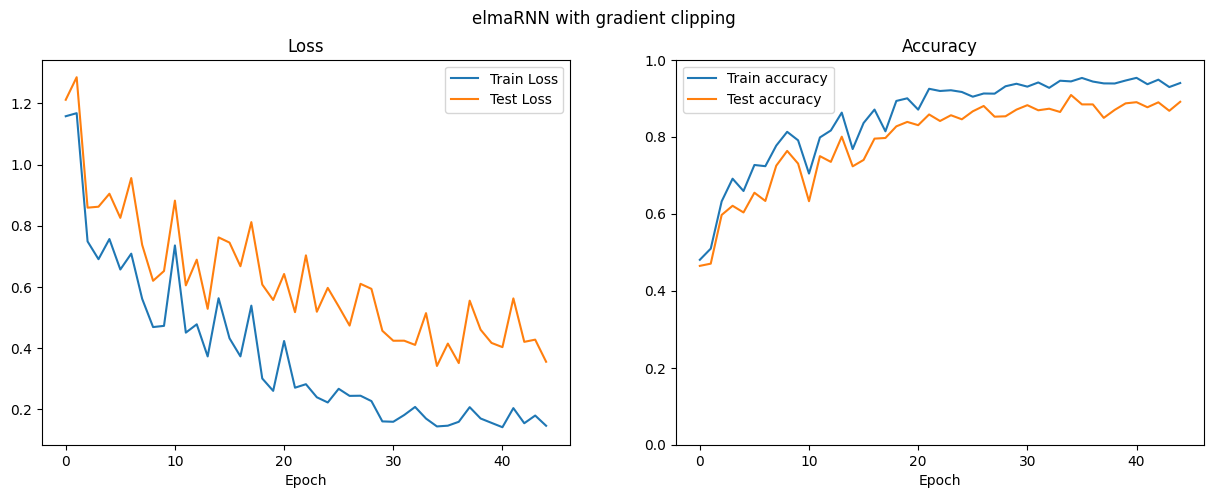

In [22]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=128, layer_size=1, num_classes=N_CLASSES).to(device)
adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=45, batch_size=128, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=True)
print_hist(history, 'elmaRNN with gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=1.0235, test=1.1405 | Accuracy: train=0.5692, test=0.5120
Epoch 2, Loss: train=1.0448, test=1.1895 | Accuracy: train=0.5041, test=0.4686
Epoch 3, Loss: train=0.8619, test=1.0269 | Accuracy: train=0.6333, test=0.5711
Epoch 4, Loss: train=0.6368, test=0.8580 | Accuracy: train=0.7368, test=0.6505
Epoch 5, Loss: train=0.5332, test=0.7569 | Accuracy: train=0.7711, test=0.7106
Epoch 6, Loss: train=0.5065, test=0.7893 | Accuracy: train=0.7975, test=0.7180
Epoch 7, Loss: train=0.4253, test=0.6374 | Accuracy: train=0.8615, test=0.7940
Epoch 8, Loss: train=0.5001, test=0.7848 | Accuracy: train=0.8315, test=0.7625
Epoch 9, Loss: train=0.3231, test=0.5660 | Accuracy: train=0.8923, test=0.8402
Epoch 10, Loss: train=0.5549, test=0.8531 | Accuracy: train=0.8147, test=0.7615
Epoch 11, Loss: train=0.2658, test=0.5882 | Accuracy: train=0.8984, test=0.8252
Epoch 12, Loss: train=0.3609, test=0.6643 | Accuracy: train=0.8702, test=0.8191
Epoch 13, Loss: train=0.5974, t

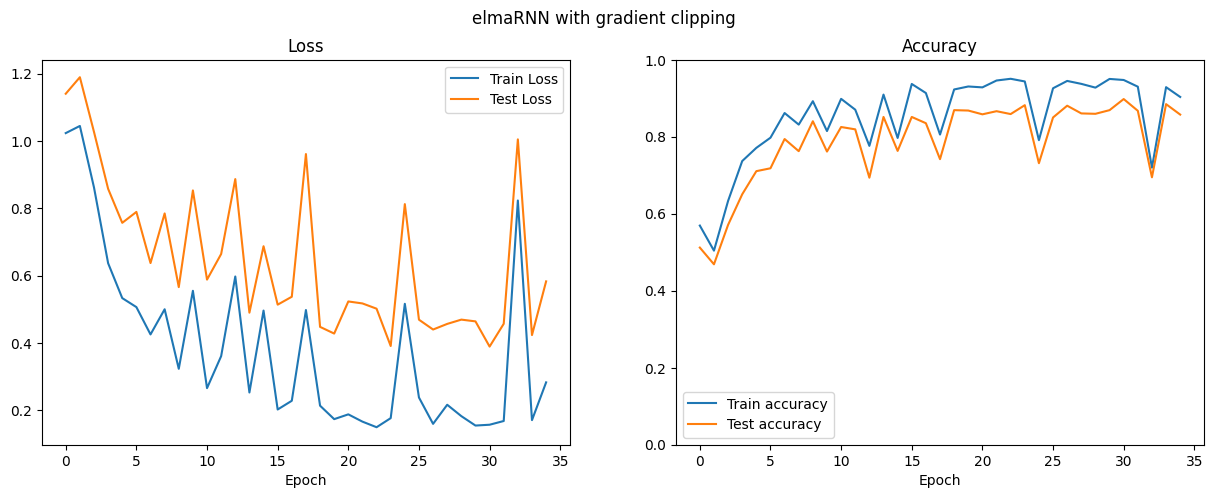

In [23]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=128, layer_size=1, num_classes=N_CLASSES).to(device)
adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=35, batch_size=64, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=True)
print_hist(history, 'elmaRNN with gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=1.0404, test=1.1380 | Accuracy: train=0.5518, test=0.4971
Epoch 2, Loss: train=0.7123, test=0.8451 | Accuracy: train=0.6780, test=0.6152
Epoch 3, Loss: train=0.5749, test=0.6914 | Accuracy: train=0.7450, test=0.6770
Epoch 4, Loss: train=0.4463, test=0.6456 | Accuracy: train=0.8268, test=0.7645
Epoch 5, Loss: train=0.5138, test=0.6733 | Accuracy: train=0.8067, test=0.7703
Epoch 6, Loss: train=0.4458, test=0.6782 | Accuracy: train=0.8609, test=0.8066
Epoch 7, Loss: train=0.3641, test=0.5801 | Accuracy: train=0.8875, test=0.8439
Epoch 8, Loss: train=0.3556, test=0.6344 | Accuracy: train=0.8927, test=0.8171
Epoch 9, Loss: train=0.2945, test=0.5772 | Accuracy: train=0.9032, test=0.8202
Epoch 10, Loss: train=0.1875, test=0.3743 | Accuracy: train=0.9453, test=0.8901
Epoch 11, Loss: train=0.4423, test=0.7111 | Accuracy: train=0.8489, test=0.7740
Epoch 12, Loss: train=0.2389, test=0.4134 | Accuracy: train=0.9170, test=0.8677
Epoch 13, Loss: train=0.1578, t

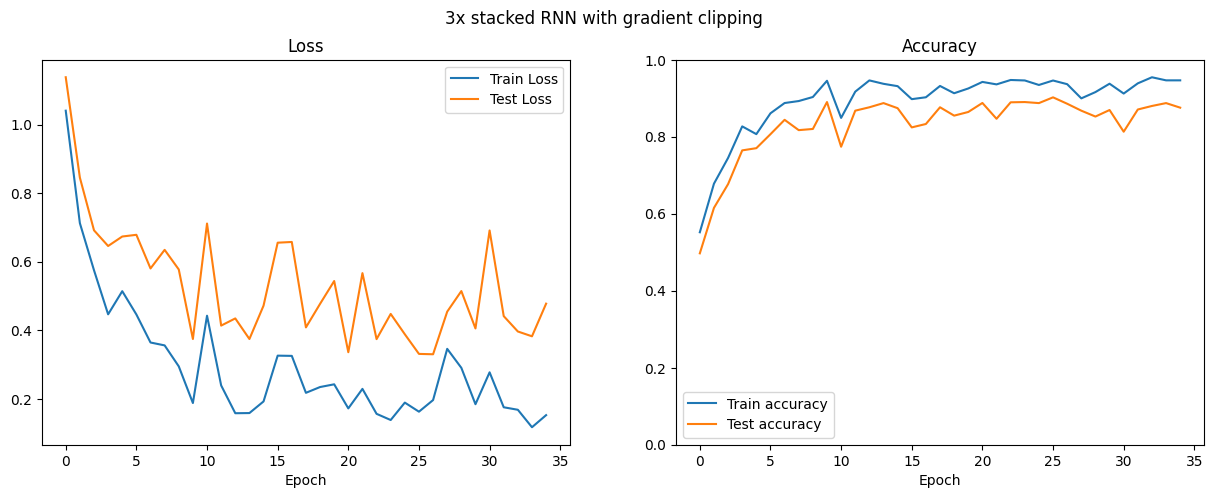

In [24]:
multi_layer_RNN = RNNModel(input_size=n_input_signals, hidden_size=128, layer_size=3, num_classes=N_CLASSES).to(device)
adam = torch.optim.Adam(multi_layer_RNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=multi_layer_RNN, n_epochs=25, batch_size=64, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=True)
print_hist(history, '3x stacked RNN with gradient clipping')
del multi_layer_RNN

#### Findings



### LSTM

In [25]:
lstm = LSTMModel(input_size=n_input_signals, hidden_size=64, layer_size=1, num_classes=N_CLASSES).to(device)

Training model...
Epoch 1, Loss: train=0.7760, test=0.9071 | Accuracy: train=0.6610, test=0.6339
Epoch 2, Loss: train=0.5607, test=0.7773 | Accuracy: train=0.8165, test=0.7017
Epoch 3, Loss: train=0.3523, test=0.7090 | Accuracy: train=0.8913, test=0.7781
Epoch 4, Loss: train=0.2312, test=0.4922 | Accuracy: train=0.9305, test=0.8510
Epoch 5, Loss: train=0.1947, test=0.5452 | Accuracy: train=0.9297, test=0.8616
Epoch 6, Loss: train=0.1868, test=0.4722 | Accuracy: train=0.9377, test=0.8666
Epoch 7, Loss: train=0.1489, test=0.4811 | Accuracy: train=0.9449, test=0.8765
Epoch 8, Loss: train=0.1427, test=0.5374 | Accuracy: train=0.9446, test=0.8677
Epoch 9, Loss: train=0.2056, test=0.7525 | Accuracy: train=0.9344, test=0.8354
Epoch 10, Loss: train=0.1663, test=0.5210 | Accuracy: train=0.9445, test=0.8836
Epoch 11, Loss: train=0.1416, test=0.4139 | Accuracy: train=0.9355, test=0.8839
Epoch 12, Loss: train=0.1178, test=0.4308 | Accuracy: train=0.9472, test=0.8789
Epoch 13, Loss: train=0.1520, t

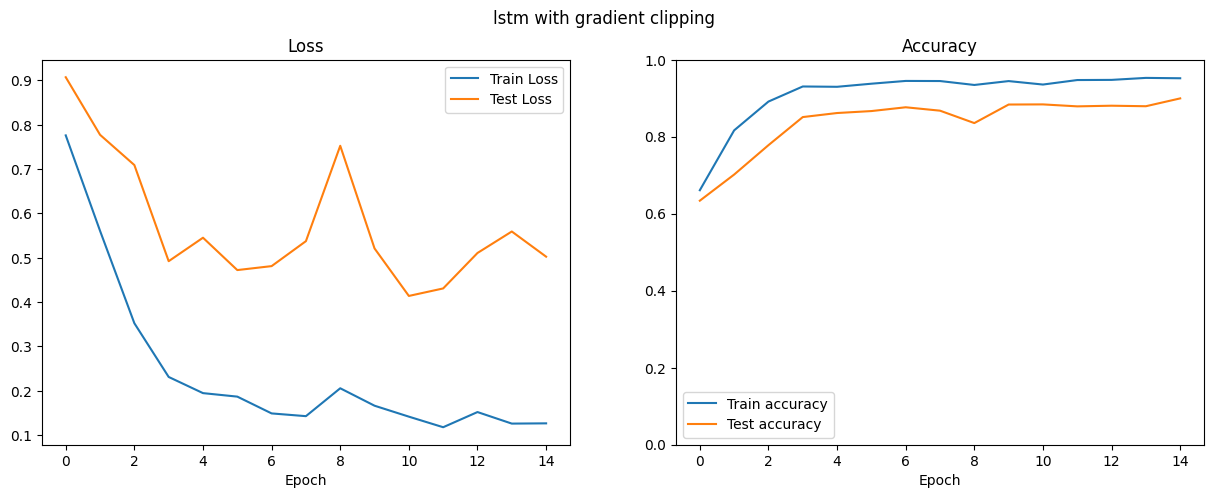

In [26]:
adam = torch.optim.Adam(lstm.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=lstm, n_epochs=15, batch_size=32, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=True)
print_hist(history, 'lstm with gradient clipping')
del lstm

#### Findings

...

### Stacked LSTMs

In [36]:
stacked_lstm = LSTMModel(input_size=n_input_signals, hidden_size=64, layer_size=1, num_classes=N_CLASSES).to(device)

In [38]:
adam = torch.optim.Adam(stacked_lstm.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=stacked_lstm, n_epochs=15, batch_size=32, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=True)
print_hist(history, 'lstm with gradient clipping')
del lstm

Training model...


RuntimeError: MPS backend out of memory (MPS allocated: 2.72 GB, other allocations: 17.23 GB, max allowed: 20.40 GB). Tried to allocate 919.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

#### Findings

...

### CNN (Conv1d)

In [ ]:
cnn_1d = CNN_1D(input_size=signal_sequence_length, num_classes=N_CLASSES).to(device)

In [ ]:
adam = torch.optim.Adam(cnn_1d.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=cnn_1d, n_epochs=25, batch_size=32, optimizer=adam, criterion=cross_entropy,
                      gradient_clipping=True)
print_hist(history, 'lstm with gradient clipping')
del cnn_1d